# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.metrics import Precision, Recall, AUC
from google.colab import runtime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

In [3]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasetsFull'
# TfDatasetsPath = 'TfDatasetsFull'

In [5]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [6]:
def augment_and_duplicate(image, label):
    augmented_images = []
    augmented_labels = []

    for _ in range(3):
        augmented_image = image
        augmented_image = tf.image.random_flip_left_right(augmented_image)
        augmented_image = tf.image.random_flip_up_down(augmented_image)
        augmented_image = tf.image.random_brightness(augmented_image, max_delta=0.2)
        augmented_image = tf.image.random_contrast(augmented_image, lower=0.7, upper=1.3)
        angle = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        augmented_image = tf.image.rot90(augmented_image, k=angle)

        augmented_images.append(augmented_image)
        augmented_labels.append(label)

    augmented_images = tf.stack(augmented_images)
    augmented_labels = tf.stack(augmented_labels)

    return augmented_images, augmented_labels

def augment_dataset(dataset):
    augmented_dataset = dataset.flat_map(
        lambda image, label: tf.data.Dataset.from_tensor_slices(augment_and_duplicate(image, label))
    )
    return augmented_dataset

trainDataset = augment_dataset(trainDataset)
len(list(trainDataset))

11340

In [7]:
trainDataset = trainDataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validDataset = validDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
trainDataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [9]:
metrics = [Precision(), Recall(), AUC(), 'accuracy']

# DenseNet201 Model

In [10]:
def createModel(input_shape, num_classes=3, learning_rate=1e-4):
    inputs = tf.keras.layers.Input(shape=input_shape, name="Input_Layer")
    base_model = tf.keras.applications.DenseNet201(weights="imagenet", input_tensor=inputs, include_top=False)
    base_model.trainable = True
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = tf.keras.layers.Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(x, x)
    x = tf.keras.layers.Reshape((height, width, channels), name="Reshape_to_Spatial")(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = tf.keras.layers.Dense(256, activation="relu", name="FC_256")(x)
    x = tf.keras.layers.BatchNormalization(name="Batch_Normalization")(x)
    x = tf.keras.layers.Dropout(0.5, name="Dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax",name="Output_Layer")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
    return model

# TRAINING

In [11]:
input_shape = (224, 224, 3)
model = createModel(input_shape, num_classes=3, learning_rate=1e-4)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ Input_Layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 136,828,355 (521.96 MB)

 Trainable params: 136,598,787 (521.08 MB)

 Non-trainable params: 229,568 (896.75 KB)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [11]:
# Defining The ReduceLRonPlateau Callback
reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5, # How much to improve the learning rate -> LR = LR*factor
    patience=3,
    verbose=1,
    mode='max',
    min_delta=0.0001, # Change in metric below this delta is considered as no change
    cooldown=0, # Number of epochs to wait before resuming normal operation after lr has been improved
    min_lr=0 # Learning Rate won't go below this
)

In [15]:
history = model.fit(trainDataset,
                        validation_data=validDataset,
                        epochs=250,
                        callbacks=[early_stopping, reduceLRCallback],
                        verbose=1)

Epoch 1/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 796s 566ms/step - accuracy: 0.5742 - auc: 0.7579 - loss: 0.9897 - precision: 0.6118 - recall: 0.4972 - val_accuracy: 0.6241 - val_auc: 0.7690 - val_loss: 1.0682 - val_precision: 0.6355 - val_recall: 0.5907 - learning_rate: 1.0000e-04
Epoch 2/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 86s 120ms/step - accuracy: 0.6622 - auc: 0.8408 - loss: 0.7776 - precision: 0.6989 - recall: 0.6026 - val_accuracy: 0.7296 - val_auc: 0.8767 - val_loss: 0.8482 - val_precision: 0.7446 - val_recall: 0.7074 - learning_rate: 1.0000e-04
Epoch 3/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 85s 119ms/step - accuracy: 0.7126 - auc: 0.8799 - loss: 0.6817 - precision: 0.7409 - recall: 0.6672 - val_accuracy: 0.6037 - val_auc: 0.7901 - val_loss: 1.0748 - val_precision: 0.6125 - val_recall: 0.5546 - learning_rate: 1.0000e-04
Epoch 4/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 86s 119ms/step - accuracy: 0.7328 - auc: 0.8919 - loss: 0.6464 - precision: 0.7589 - recall: 0.6949 - val_accuracy: 0.7056 - val_auc: 0.

# FINE-TUNING

In [12]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CSEN-240-Project/KerasModels/DenseNet201.keras')

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7), loss="categorical_crossentropy", metrics=metrics)

In [14]:
history = model.fit( trainDataset,
                         validation_data=validDataset,
                         epochs=250,
                         callbacks=[early_stopping, reduceLRCallback],
                         verbose=1)

Epoch 1/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 813s 589ms/step - accuracy: 0.9195 - auc: 0.9906 - loss: 0.1760 - precision: 0.9217 - recall: 0.9164 - val_accuracy: 0.8935 - val_auc: 0.9707 - val_loss: 0.3686 - val_precision: 0.8942 - val_recall: 0.8926 - learning_rate: 1.0000e-07
Epoch 2/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 86s 120ms/step - accuracy: 0.9204 - auc: 0.9911 - loss: 0.1711 - precision: 0.9232 - recall: 0.9181 - val_accuracy: 0.8926 - val_auc: 0.9708 - val_loss: 0.3664 - val_precision: 0.8949 - val_recall: 0.8907 - learning_rate: 1.0000e-07
Epoch 3/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 85s 119ms/step - accuracy: 0.9268 - auc: 0.9925 - loss: 0.1562 - precision: 0.9300 - recall: 0.9248 - val_accuracy: 0.8935 - val_auc: 0.9709 - val_loss: 0.3670 - val_precision: 0.8942 - val_recall: 0.8917 - learning_rate: 1.0000e-07
Epoch 4/250
709/709 ━━━━━━━━━━━━━━━━━━━━ 85s 119ms/step - accuracy: 0.9226 - auc: 0.9912 - loss: 0.1720 - precision: 0.9251 - recall: 0.9216 - val_accuracy: 0.8954 - val_auc: 0.

# PLOTS

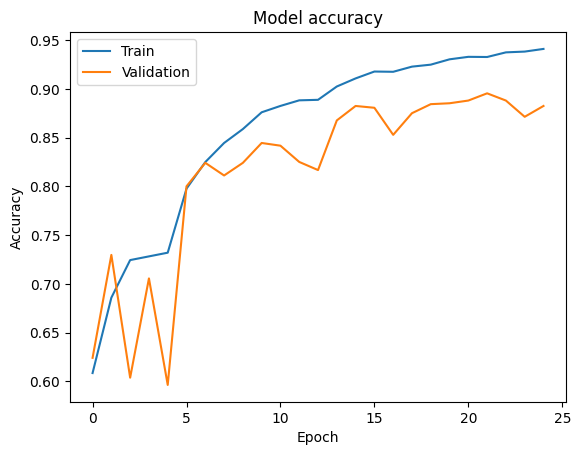

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

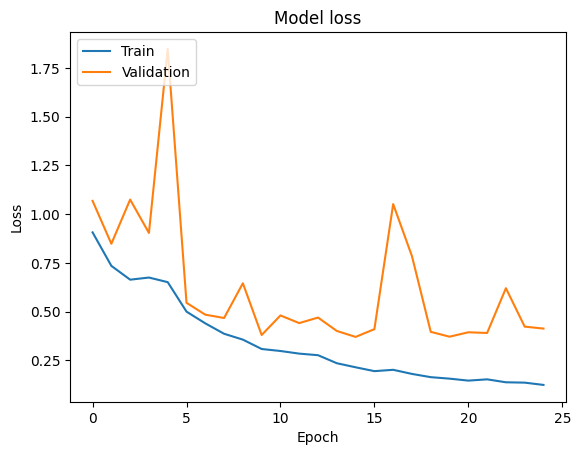

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# PR CURVE

In [15]:
valid_labels = []
for xBatch, yBatch in validDataset:
    valid_labels.extend(np.argmax(yBatch, axis=1))
predictions = model.predict(validDataset)
predicted_classes = np.argmax(predictions, axis=1)
yTrue = np.eye(3)[valid_labels]
yPred = predictions
thresholds = {}

68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 322ms/step


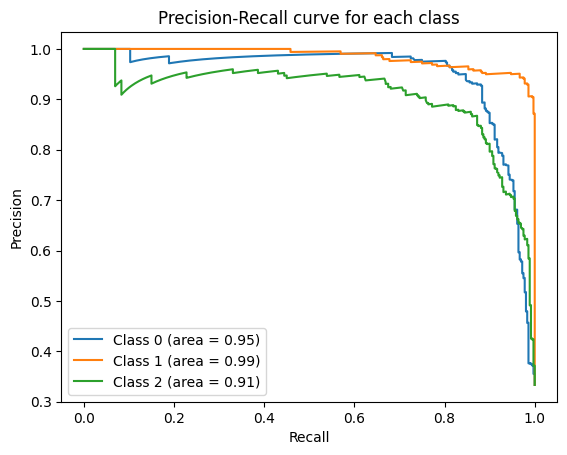

In [16]:
for class_idx in range(3):
    precision, recall, thresholds_pr = precision_recall_curve(yTrue[:, class_idx], yPred[:, class_idx])

    f1_scores = 2 * (precision * recall) / (precision + recall)

    optimal_threshold_pr = thresholds_pr[np.argmax(f1_scores)]
    thresholds[class_idx] = optimal_threshold_pr

    plt.plot(recall, precision, label=f'Class {class_idx} (area = {auc(recall, precision):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="best")
plt.show()

In [18]:
print("Optimal thresholds for each class (based on maximum F1 score):")
for class_idx, threshold in thresholds.items():
    print(f"Class {class_idx}: {threshold}")

Optimal thresholds for each class (based on maximum F1 score):
Class 0: 0.5766013860702515
Class 1: 0.2765175998210907
Class 2: 0.5911226272583008


# TESTING

In [19]:
def customPredict(yPred, thresholds):
    predictions = np.zeros_like(yPred)
    for i in thresholds.keys():
        threshold = thresholds[i]
        predictions[:, i] = (yPred[:, i] >= threshold).astype(int)
    predictions = np.argmax(predictions * yPred, axis=1)
    return predictions

In [20]:
test_labels = []
for xBatch, yBatch in testDataset:
    test_labels.extend(np.argmax(yBatch, axis=1))
predictions = customPredict(model.predict(testDataset), thresholds)
# predictions = np.argmax(model.predict(testDataset), axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step


In [21]:
report = classification_report(test_labels, predictions, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       180
  Osteopenia       0.97      0.94      0.96       180
Osteoporosis       0.94      0.90      0.92       180

    accuracy                           0.94       540
   macro avg       0.94      0.94      0.94       540
weighted avg       0.94      0.94      0.94       540



Text(95.72222222222221, 0.5, 'True Label')

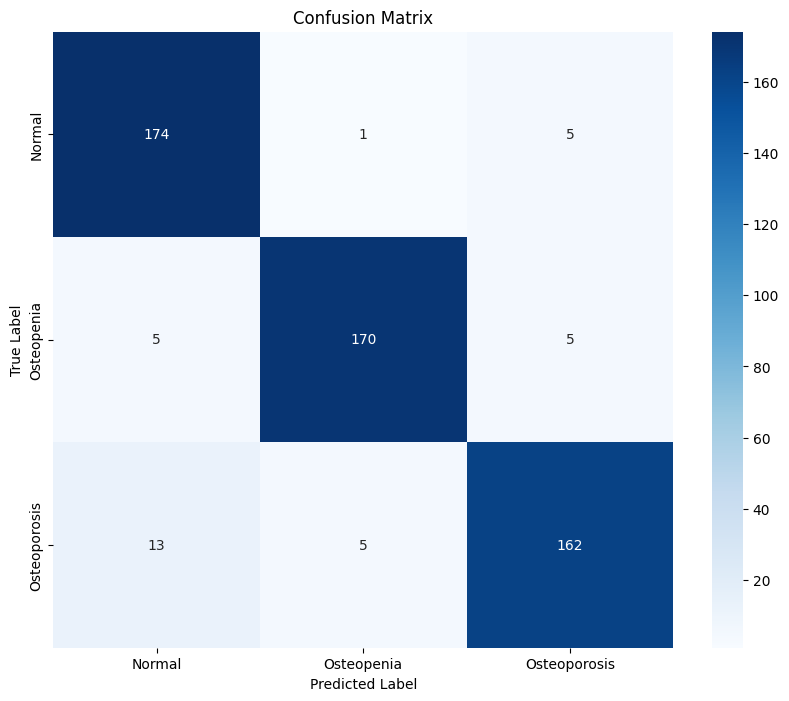

In [22]:
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [23]:
model.save('/content/drive/MyDrive/CSEN-240-Project/KerasModels/DenseNet201.keras')

In [24]:
runtime.unassign()